## **Imports**

In [1]:
!pip install gdown

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import cv2
import math
import gdown

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

## **Utility Functions**

In [3]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def load_prebuilt_model(folder_id, root, model_name):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            load_prebuilt_model(file['id'], root+'/'+file['title'], model_name)
        else:
            # download_mimetype = None
            if file['title'] == model_name:
              filename = '{}{}'.format(root+'/', file['title'])
              try:
                  file.GetContentFile(filename)
              except:
                  print('FAILED')
                  f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass

def create_restnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons=256):
    restnet_cnn_layers = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet',
                                                )
    restnet_cnn_layers.trainable = False
    last_conv_layer_output = restnet_cnn_layers.get_layer('conv5_block3_out').output

    pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(last_conv_layer_output)

    # Custom classification layers
    dense_layer_1 = tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer)(pooling_layer)
    dense_layer_dropout_1 = tf.keras.layers.Dropout(rate=dropout_rate)(dense_layer_1)
    output_layer = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(dense_layer_dropout_1)

    # Create a model with both convolutional and classification layers
    model = Model(inputs=restnet_cnn_layers.input, outputs=output_layer)

    return model

def get_mismatches(y_true, y_pred, BATCH_SIZE):
    num_mismatches = 0
    mismatch_tensor_indexes = {}
    for i in range(len(y_true)):
      if y_true[i] != y_pred[i]:
        num_mismatches += 1
        key = (i//BATCH_SIZE)
        tensor_index = (i % BATCH_SIZE)
        if mismatch_tensor_indexes.get(key) is not None:
          mismatch_tensor_indexes[key].append((tensor_index, i))
        else:
          mismatch_tensor_indexes[key] = [(tensor_index, i)]
    return num_mismatches, mismatch_tensor_indexes

def show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches):
    i=0
    total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
    tensor_batch = 0
    plt.figure(figsize=(15, (math.ceil(num_mismatches/30)*20)))
    for images, labels in test_ds.take(total_tensor_batches):
      if mismatch_tensor_indexes.get(tensor_batch) is not None:
        for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
          ax = plt.subplot(math.ceil(num_mismatches/4), 4, i + 1)
          plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1
      tensor_batch += 1

## **Step 1: Load the Train, Validation and Test tensorflow datasets that was created in Image_Dataset_Prep.ipynb**

In [15]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

PRODUCT_CATEGORY = 'clothes' # change this to the other categories as required (i.e. bag, schuhe or waesche)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1dNM1ApTB1245YhEvujWAY7LX4xiTV8Nh' # Change this to the relevant product category GDrive folder id

root = './data/processed/'+PRODUCT_CATEGORY

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

if not os.path.isdir("./data/processed/"+PRODUCT_CATEGORY):
  os.mkdir('./data/processed/'+PRODUCT_CATEGORY)

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()

Creating folder: ./data/processed/clothes/test_dataset/2259970139835365178
Creating folder: ./data/processed/clothes/test_dataset/2259970139835365178/00000000.shard
Creating folder: ./data/processed/clothes/val_dataset/12753985873845356431
Creating folder: ./data/processed/clothes/val_dataset/12753985873845356431/00000000.shard
Creating folder: ./data/processed/clothes/train_dataset/17551521819505631909
Creating folder: ./data/processed/clothes/train_dataset/17551521819505631909/00000000.shard


In [18]:
COLAB_FOLDER = './data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above

CLASSES = ['clothes_0_model_front'
           , 'clothes_1_zoomed'
           , 'clothes_2_model_back'
           , 'clothes_3_ghost'
           , 'clothes_4_look'
           ]

# CLASSES = ['bag_0_front'
#            , 'bag_1_side'
#            , 'bag_2_inside'
#            , 'bag_3_back'
#            , 'bag_4_look'
#            ]

train_ds = tf.data.Dataset.load(f'{COLAB_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.Dataset.load(f'{COLAB_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.Dataset.load(f'{COLAB_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')

In [19]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
clothes_0_model_front occurs 171 times
clothes_1_zoomed occurs 187 times
clothes_2_model_back occurs 145 times
clothes_3_ghost occurs 140 times
clothes_4_look occurs 125 times


In [20]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
clothes_0_model_front occurs 58 times
clothes_1_zoomed occurs 52 times
clothes_2_model_back occurs 54 times
clothes_3_ghost occurs 46 times
clothes_4_look occurs 46 times


In [21]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
clothes_0_model_front occurs 51 times
clothes_1_zoomed occurs 58 times
clothes_2_model_back occurs 46 times
clothes_3_ghost occurs 43 times
clothes_4_look occurs 49 times


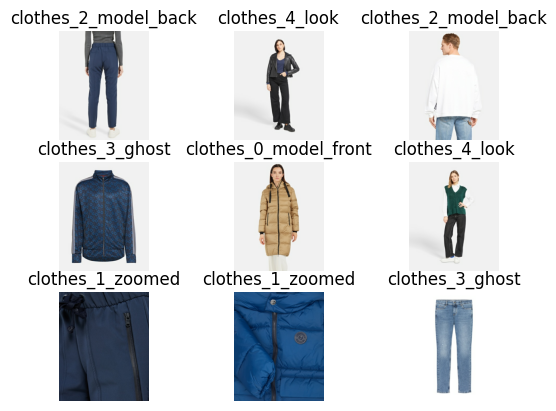

In [22]:
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")


## **Step 2: Create, Train, Validate and Test models**

**NOTE: The best model (after hyperparameter tuning loop) will be saved automatically in the Colab env under the folder ./models. This will need to be moved to the BestSecret GDrive**

In [23]:
# Test out different hyper-parameters

ACTIVATIONS = ['leaky_relu'
              #  , 'relu'
              #  , 'elu'
              #  , 'tanh'
              #  , 'selu'
              ]
INITIALIZERS = ['glorot_uniform'
                # , 'glorot_normal'
                # , 'he_normal'
                # , 'lecun_normal'
               ]


KERNEL_REGULARIZERS = [ None
                      #  , 'l1'
                      #  , 'l2'
                      #  , 'l1_l2'
                      ]

DROPOUT_RATE = [0.0
                # , 0.05
                # , 0.1
                # , 0.2
                # , 0.25
                ]
NUM_START_CNN_NEURONS = [32]
NUM_DENSE_NEURONS = [256]

EPOCHS = 20
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 0.001
FINAL_LEARNING_RATE = 0.00001
LEARNING_RATE_DECAY_FACTOR = (FINAL_LEARNING_RATE / INITIAL_LEARNING_RATE)**(1/EPOCHS)
STEPS_PER_EPOCH = len(train_ds) # this should actually be set to int(train_size/batch_size), but since the len(train_ds) returns the number of training records divided by the batch size already we just set it to that


In [24]:
# The caching helps speed up training after the first batch as the data is pulled from the cache for subsequent batches
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Step 2.1: RestNet50 Model (no finetunning of CNN layers, just the Dense layers)**



1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.7396

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 15s 464ms/step - loss: 0.7049 - accuracy: 0.7396 - val_loss: 0.2898 - val_accuracy: 0.8984
Epoch 2/20
24/24 [==============================] - 10s 422ms/step - loss: 0.1838 - accuracy: 0.9310 - val_loss: 0.2585 - val_accuracy: 0.9258
Epoch 3/20
24/24 [==============================] - 9s 396ms/step - loss: 0.1725 - accuracy: 0.9258 - val_loss: 0.3112 - val_accuracy: 0.9023
Epoch 4/20
24/24 [==============================] - 10s 416ms/step - loss: 0.1408 - accuracy: 0.9505 - val_loss: 0.1703 - val_accuracy: 0.9648
Epoch 5/20
24/24 [==============================] - 10s 409ms/step - loss: 0.0707 - accuracy: 0.9818 - val_loss: 0.1641 - val_accuracy: 0.9727
Epoch 6/20
24/24 [==============================] - 10s 404ms/step - loss: 0.0595 - accuracy: 0.9831 - val_loss: 0.1627 - val_accuracy: 0.9727
Epoch 7/20
24/24 [==============================] - 10s 402ms/step - loss: 0.0544 - accuracy: 0.9870 - val_loss: 0.1569 - val_accuracy: 0.9766
Epoch 8/20


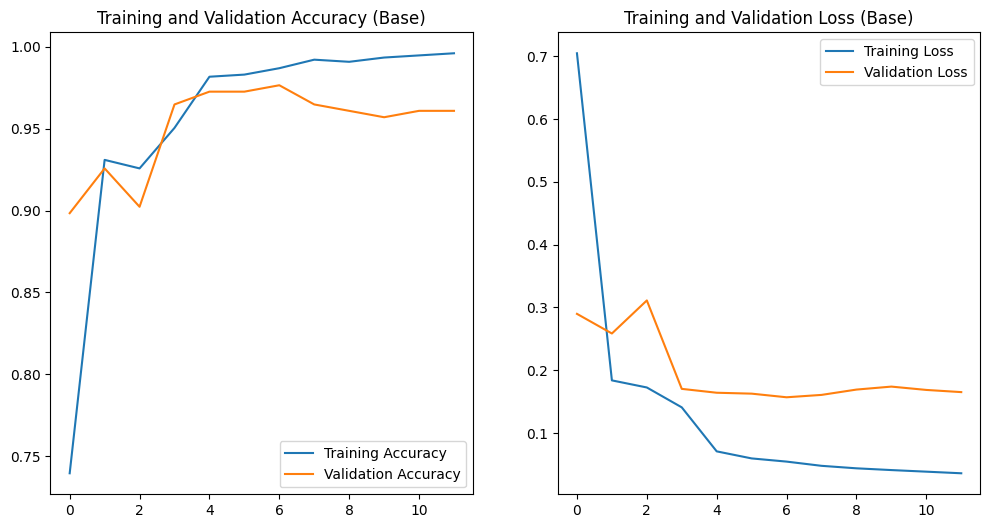

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 922ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:09,  1.37s/it]

1/1 [==============================] - 0s 76ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.96it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  2.18it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.33it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.39it/s]

1/1 [==============================] - 1s 883ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]



Accuracy of base model on test data: 97.98%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.97      0.97      0.97        58
           2       0.96      0.98      0.97        46
           3       1.00      0.98      0.99        43
           4       1.00      1.00      1.00        49

    accuracy                           0.98       247
   macro avg       0.98      0.98      0.98       247
weighted avg       0.98      0.98      0.98       247

    0   1   2   3   4
0  50   0   1   0   0
1   1  56   1   0   0
2   0   1  45   0   0
3   0   1   0  42   0
4   0   0   0   0  49


Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0       97.975709

In [25]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Dense_Neurons', 'Accuracy_Score'])

restnet_model = None
i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        restnet_model = create_restnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        restnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])
                        restnet_model.layers[1].trainable = False

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_restnet50_model.h5", save_best_only=True)

                        history_base = restnet_model.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(restnet_model, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

In [26]:
pd.DataFrame(confusion_matrix(y_true, y_pred))

0   1   2   3   4
0  50   0   1   0   0
1   1  56   1   0   0
2   0   1  45   0   0
3   0   1   0  42   0
4   0   0   0   0  49

In [27]:
num_mismatches, mismatch_tensor_indexes = get_mismatches(y_true, y_pred, BATCH_SIZE)
print(f"Number of mismatches = {num_mismatches}")
mismatch_tensor_indexes

Number of mismatches = 5


{1: [(26, 58)], 4: [(21, 149), (28, 156)], 5: [(0, 160)], 7: [(17, 241)]}

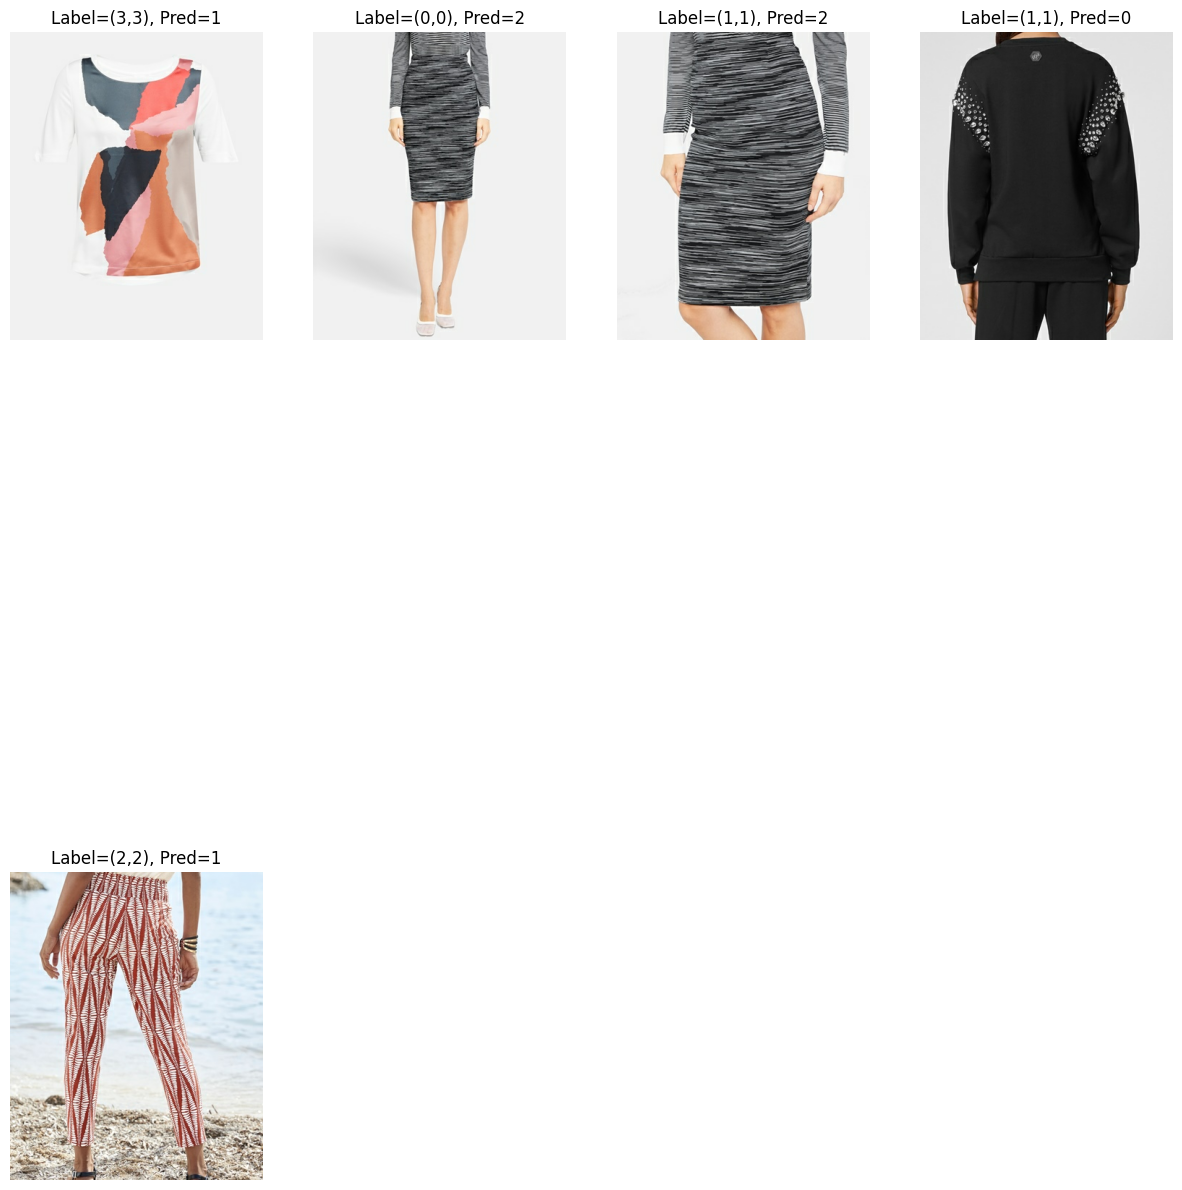

In [29]:
show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches)

In [ ]:
# Run this only if you want to see ALL test images with label and prediction

# import math
# i=0
# total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
# plt.figure(figsize=(15, 200))
# for images, labels in test_ds.take(total_tensor_batches):
#   for j in range(len(labels)):
#     # print(f'{i}, {j}')
#     ax = plt.subplot(math.ceil(len(y_pred)/5), 5, i + 1)
#     plt.imshow(images[j].numpy().astype("uint8"))
#     plt.title(f"Label={labels[j]}, Pred={y_pred[i]}")
#     plt.axis("off")
#     i += 1

In [31]:
for layer in restnet_model.layers:
    print(f"{layer.name} trainable={layer.trainable}")

input_1 trainable=False
conv1_pad trainable=False
conv1_conv trainable=False
conv1_bn trainable=False
conv1_relu trainable=False
pool1_pad trainable=False
pool1_pool trainable=False
conv2_block1_1_conv trainable=False
conv2_block1_1_bn trainable=False
conv2_block1_1_relu trainable=False
conv2_block1_2_conv trainable=False
conv2_block1_2_bn trainable=False
conv2_block1_2_relu trainable=False
conv2_block1_0_conv trainable=False
conv2_block1_3_conv trainable=False
conv2_block1_0_bn trainable=False
conv2_block1_3_bn trainable=False
conv2_block1_add trainable=False
conv2_block1_out trainable=False
conv2_block2_1_conv trainable=False
conv2_block2_1_bn trainable=False
conv2_block2_1_relu trainable=False
conv2_block2_2_conv trainable=False
conv2_block2_2_bn trainable=False
conv2_block2_2_relu trainable=False
conv2_block2_3_conv trainable=False
conv2_block2_3_bn trainable=False
conv2_block2_add trainable=False
conv2_block2_out trainable=False
conv2_block3_1_conv trainable=False
conv2_block3_1_b

In [32]:
restnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 427, 350, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 433, 356, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 214, 175, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 214, 175, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### **Step 2.2: RestNet50 Model (make layer5 of the RestNet model trainable)**



1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.6484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 14s 446ms/step - loss: 0.9112 - accuracy: 0.6484 - val_loss: 0.4474 - val_accuracy: 0.7969
Epoch 2/20
24/24 [==============================] - 10s 410ms/step - loss: 0.2626 - accuracy: 0.8906 - val_loss: 0.2631 - val_accuracy: 0.9219
Epoch 3/20
24/24 [==============================] - 10s 419ms/step - loss: 0.1662 - accuracy: 0.9414 - val_loss: 0.2000 - val_accuracy: 0.9648
Epoch 4/20
24/24 [==============================] - 10s 418ms/step - loss: 0.1127 - accuracy: 0.9688 - val_loss: 0.1904 - val_accuracy: 0.9648
Epoch 5/20
24/24 [==============================] - 10s 412ms/step - loss: 0.0938 - accuracy: 0.9727 - val_loss: 0.1843 - val_accuracy: 0.9648
Epoch 6/20
24/24 [==============================] - 10s 406ms/step - loss: 0.0814 - accuracy: 0.9792 - val_loss: 0.1764 - val_accuracy: 0.9766
Epoch 7/20
24/24 [==============================] - 10s 403ms/step - loss: 0.0730 - accuracy: 0.9818 - val_loss: 0.1724 - val_accuracy: 0.9766
Epoch 8/20

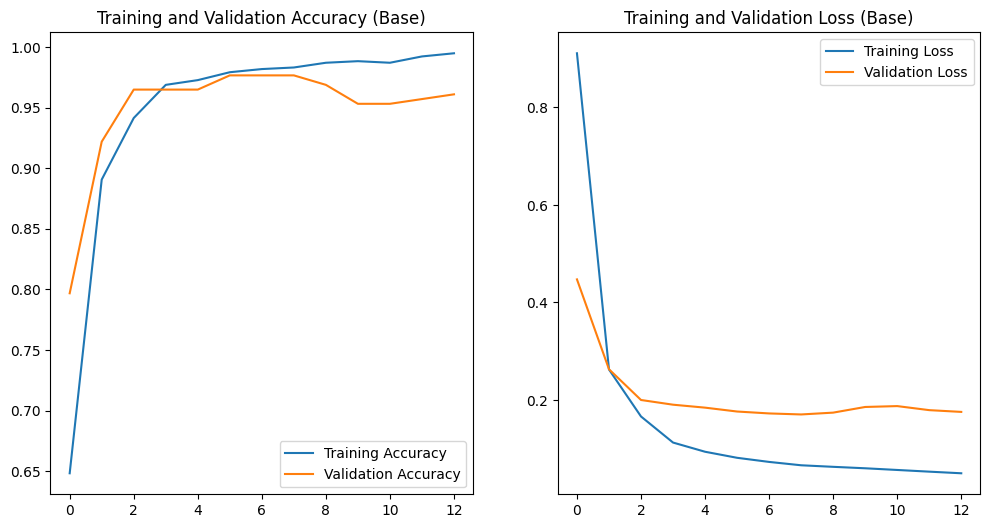

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 885ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:09,  1.33s/it]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:04,  1.30it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:02,  1.70it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  2.00it/s]

1/1 [==============================] - 0s 70ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  2.21it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.37it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.48it/s]

1/1 [==============================] - 1s 890ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]



Accuracy of base model on test data: 97.57%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        51
           1       0.97      1.00      0.98        58
           2       0.98      0.96      0.97        46
           3       1.00      0.98      0.99        43
           4       0.98      0.98      0.98        49

    accuracy                           0.98       247
   macro avg       0.98      0.97      0.98       247
weighted avg       0.98      0.98      0.98       247

    0   1   2   3   4
0  49   0   1   0   1
1   0  58   0   0   0
2   1   1  44   0   0
3   0   1   0  42   0
4   1   0   0   0  48


Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0        97.57085

In [33]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Dense_Neurons', 'Accuracy_Score'])

restnet_model = None
i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        restnet_model = create_restnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        restnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])
                        restnet_model.trainable = True
                        # Make CNN Layer 5 of the RestNet50 model trainable but keep the others locked
                        for layer in restnet_model.layers:
                            if not (("conv5_" in layer.name or "dense_" in layer.name or "global_average_pooling" in layer.name or "dropout_" in layer.name) and "_bn" not in layer.name):
                                layer.trainable = False

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_restnet50_model_ft_l5.h5", save_best_only=True)

                        history_base = restnet_model.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(restnet_model, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

In [36]:
for layer in restnet_model.layers:
    print(f"{layer.name} trainable={layer.trainable}")

input_4 trainable=False
conv1_pad trainable=False
conv1_conv trainable=False
conv1_bn trainable=False
conv1_relu trainable=False
pool1_pad trainable=False
pool1_pool trainable=False
conv2_block1_1_conv trainable=False
conv2_block1_1_bn trainable=False
conv2_block1_1_relu trainable=False
conv2_block1_2_conv trainable=False
conv2_block1_2_bn trainable=False
conv2_block1_2_relu trainable=False
conv2_block1_0_conv trainable=False
conv2_block1_3_conv trainable=False
conv2_block1_0_bn trainable=False
conv2_block1_3_bn trainable=False
conv2_block1_add trainable=False
conv2_block1_out trainable=False
conv2_block2_1_conv trainable=False
conv2_block2_1_bn trainable=False
conv2_block2_1_relu trainable=False
conv2_block2_2_conv trainable=False
conv2_block2_2_bn trainable=False
conv2_block2_2_relu trainable=False
conv2_block2_3_conv trainable=False
conv2_block2_3_bn trainable=False
conv2_block2_add trainable=False
conv2_block2_out trainable=False
conv2_block3_1_conv trainable=False
conv2_block3_1_b

### **Step 2.3: RestNet50 Model (make ALL layers of the RestNet model trainable)**



1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.7207 - accuracy: 0.7214

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 15s 462ms/step - loss: 0.7207 - accuracy: 0.7214 - val_loss: 0.3696 - val_accuracy: 0.8750
Epoch 2/20
24/24 [==============================] - 10s 428ms/step - loss: 0.2223 - accuracy: 0.9141 - val_loss: 0.2911 - val_accuracy: 0.9023
Epoch 3/20
24/24 [==============================] - 10s 418ms/step - loss: 0.1707 - accuracy: 0.9336 - val_loss: 0.1811 - val_accuracy: 0.9805
Epoch 4/20
24/24 [==============================] - 10s 409ms/step - loss: 0.1066 - accuracy: 0.9701 - val_loss: 0.1697 - val_accuracy: 0.9805
Epoch 5/20
24/24 [==============================] - 10s 404ms/step - loss: 0.0867 - accuracy: 0.9766 - val_loss: 0.1682 - val_accuracy: 0.9766
Epoch 6/20
24/24 [==============================] - 9s 375ms/step - loss: 0.0747 - accuracy: 0.9779 - val_loss: 0.1693 - val_accuracy: 0.9688
Epoch 7/20
24/24 [==============================] - 10s 402ms/step - loss: 0.0690 - accuracy: 0.9844 - val_loss: 0.1594 - val_accuracy: 0.9805
Epoch 8/20


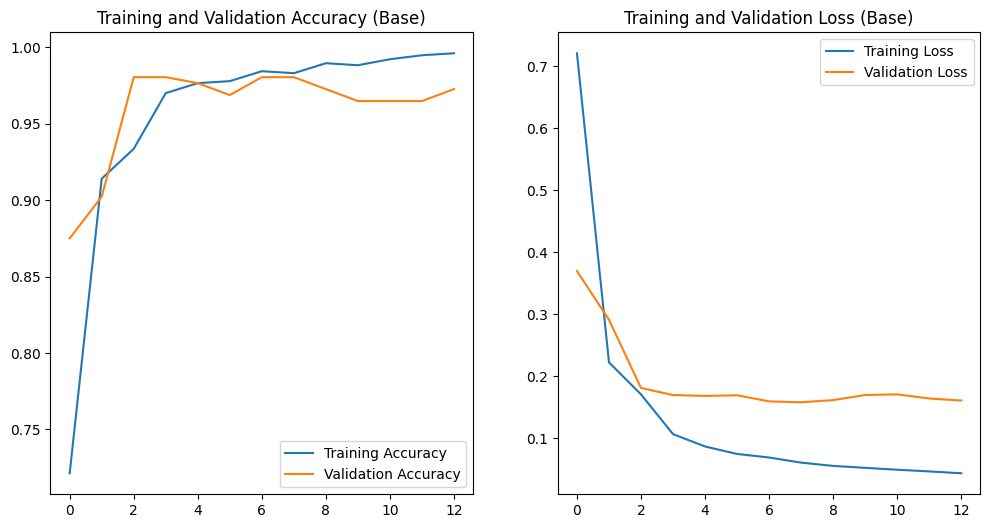

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 921ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:09,  1.36s/it]

1/1 [==============================] - 0s 82ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:02,  1.68it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.97it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  2.18it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.34it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.45it/s]

1/1 [==============================] - 1s 915ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]



Accuracy of base model on test data: 97.57%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        51
           1       0.97      0.98      0.97        58
           2       0.98      0.96      0.97        46
           3       0.98      0.98      0.98        43
           4       0.98      1.00      0.99        49

    accuracy                           0.98       247
   macro avg       0.98      0.98      0.98       247
weighted avg       0.98      0.98      0.98       247

    0   1   2   3   4
0  49   0   1   0   1
1   0  57   0   1   0
2   1   1  44   0   0
3   0   1   0  42   0
4   0   0   0   0  49


Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0        97.57085

In [34]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Dense_Neurons', 'Accuracy_Score'])

restnet_model = None
i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        restnet_model = create_restnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        restnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])
                        restnet_model.layers[1].trainable = True

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_restnet50_model.h5", save_best_only=True)

                        history_base = restnet_model.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(restnet_model, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

## **Spep 3: Loading a prebuilt model and using it to predict**

In [13]:
# Load prebuilt and tuned model from GDrive onto Colab env directory

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
folder_id = '1JUgLVKtQinZkC79GIsnu6YwbAESWpntX'

root = './models'

if not os.path.isdir(root):
  os.mkdir(root)

load_prebuilt_model(folder_id, root, 'clothes_resnet50_func_model_97%.h5')
f.close()

In [16]:
# Predict using the prebuilt model
from tensorflow.keras.models import load_model

# load model
model = load_model('./models/clothes_resnet50_func_model_97%.h5')

y_true, y_pred = eval_model_on_test(model, test_ds)
score = (accuracy_score(y_true, y_pred)*100)
print("\n\nAccuracy of base model on test data: %.2f%%" % score)
print(classification_report(y_true, y_pred)) #, target_names=CLASSES
print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 902ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:09,  1.39s/it]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:02,  1.68it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.97it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  2.19it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.36it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.46it/s]

1/1 [==============================] - 5s 5s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Accuracy of base model on test data: 97.17%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        51
           1       0.97      0.97      0.97        58
           2       0.94      0.96      0.95        46
           3       0.98      0.98      0.98        43
           4       1.00      1.00      1.00        49

    accuracy                           0.97       247
   macro avg       0.97      0.97      0.97       247
weighted avg       0.97      0.97      0.97       247

    0   1   2   3   4
0  49   0   2   0   0
1   0  56   1   1   0
2   1   1  44   0   0
3   0   1   0  42   0
4   0   0   0   0  49
